## Scaffold Data

In [1]:
import torch
from dataset.get_datasets import get_dataset
import warnings

from dataset.scaffold import ogbg_with_smiles
import os 
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('./plotter/')
from plotter.plot import convert_idx_list, Orig_Plotter

warnings.filterwarnings('ignore')

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)    

class Args:
    def __init__(self):
        self.dataset = 'ogbg-molhiv'
        self.device = device
        self.batch_size = 128
        
args = Args()


labeled_dataset = get_dataset(args, './raw_data')
labeled_dataset_list = [data for data in labeled_dataset]
smile_path = os.path.join('./raw_data', '_'.join(args.dataset.split('-')), 'mapping/mol.csv.gz')
smiles_df = pd.read_csv(smile_path, compression='gzip', usecols=['smiles'])
smiles = smiles_df['smiles'].tolist() 

new_labeled_dataset = ogbg_with_smiles(name = args.dataset,
                                   root = './raw_data',
                                   data_list = labeled_dataset_list, 
                                   smile_list = smiles)
label_split_idx_scaffold = new_labeled_dataset.get_idx_split(split_type = 'scaffold')
label_split_idx_random = new_labeled_dataset.get_idx_split(split_type = 'random')

cuda


In [48]:
from dataset.scaffold import get_scaffold_split_info, _generate_scaffold, generate_scaffolds_dict

label_scaffold_split_idx = new_labeled_dataset.get_idx_split(split_type = 'scaffold')

_,all_scaffolds_set = generate_scaffolds_dict(smiles)
print(f'There are {len(all_scaffolds_set)} scaffolds in total and {len(new_labeled_dataset)} molecules in the dataset.')

all_scaffolds_smiles = [tup[0] for tup in all_scaffolds_set]

There are 20670 scaffolds in total and 41127 molecules in the dataset.


In [49]:
train_smiles = [smiles[i] for i in label_scaffold_split_idx['train']]
_, train_scaffold = generate_scaffolds_dict(train_smiles)
train_scaffold_num = dict([(tup[0], len(tup[1])) for tup in train_scaffold])

valid_smiles = [smiles[i] for i in label_scaffold_split_idx['valid']]
_, valid_scaffold = generate_scaffolds_dict(valid_smiles)
valid_scaffold_num = dict([(tup[0], len(tup[1])) for tup in valid_scaffold])

test_smiles = [smiles[i] for i in label_scaffold_split_idx['test']]
_, test_scaffold = generate_scaffolds_dict(test_smiles)
test_scaffold_num = dict([(tup[0], len(tup[1])) for tup in test_scaffold])
#test_scaffold_num = dict(sorted(test_scaffold_num.items(), key=lambda item: item[0]))

In [50]:
for scaffold_smile in all_scaffolds_smiles:
    if scaffold_smile not in train_scaffold_num:
        train_scaffold_num[scaffold_smile] = 0
    if scaffold_smile not in valid_scaffold_num:
        valid_scaffold_num[scaffold_smile] = 0
    if scaffold_smile not in test_scaffold_num:
        test_scaffold_num[scaffold_smile] = 0
        
train_scaffold_num = dict(sorted(train_scaffold_num.items(), key=lambda item: item[0]))
valid_scaffold_num = dict(sorted(valid_scaffold_num.items(), key=lambda item: item[0]))
test_scaffold_num = dict(sorted(test_scaffold_num.items(), key=lambda item: item[0]))

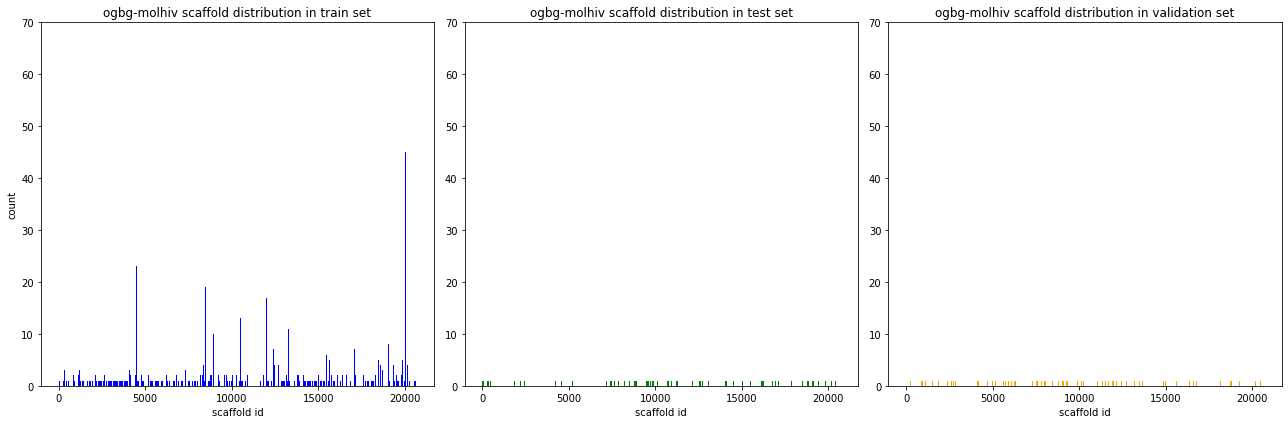

In [51]:


fig = plt.figure(figsize=(18, 6))

# Plot for train set
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
keys = list(train_scaffold_num.keys())
counts = list(train_scaffold_num.values())
indices = list(range(len(keys)))
plt.bar(indices, counts, color='blue')
plt.xlabel('scaffold id')
plt.ylabel('count')
plt.ylim(0, 70)  # Set y limit
plt.title(f'{args.dataset} scaffold distribution in train set')

# Plot for validation set
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
keys = list(valid_scaffold_num.keys())
counts = list(valid_scaffold_num.values())
indices = list(range(len(keys)))
plt.bar(indices, counts, color = 'orange')
plt.xlabel('scaffold id')
plt.ylim(0, 70)  # Set y limit
plt.title(f'{args.dataset} scaffold distribution in validation set')

# Plot for test set
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
keys = list(test_scaffold_num.keys())
counts = list(test_scaffold_num.values())
indices = list(range(len(keys)))
plt.bar(indices, counts, color = 'green')
plt.xlabel('scaffold id')
plt.ylim(0, 70)  # Set y limit
plt.title(f'{args.dataset} scaffold distribution in test set')


plt.tight_layout()
plt.savefig(f'figures/scaffold_distribution_{args.dataset}.png', facecolor='w')
plt.show()


In [49]:
scaffold_split_dict = {}
scaffold_num_dict = {}
for scaffold_smile in all_scaffolds_smiles:
    if train_scaffold_num[scaffold_smile] > 0:
        scaffold_split_dict[scaffold_smile] = 'train'
        scaffold_num_dict[scaffold_smile] = train_scaffold_num[scaffold_smile]
    elif valid_scaffold_num[scaffold_smile] > 0:
        scaffold_split_dict[scaffold_smile] = 'valid'
        scaffold_num_dict[scaffold_smile] = valid_scaffold_num[scaffold_smile]
    else:
        scaffold_split_dict[scaffold_smile] = 'test'
        scaffold_num_dict[scaffold_smile] = test_scaffold_num[scaffold_smile]


In [50]:
scaffold_split_df = pd.DataFrame.from_dict(scaffold_split_dict, orient='index')
scaffold_split_df.reset_index(inplace=True)

scaffold_split_df.columns = ['scaffold', 'split']

scaffold_split_df['num'] = scaffold_split_df['scaffold'].map(scaffold_num_dict)

print(scaffold_split_df['split'].value_counts())
scaffold_split_df.head()

train    12444
valid     4113
test      4113
Name: split, dtype: int64


,scaffold,split,num
0,c1ccccc1,train,2090
1,c1ccncc1,train,165
2,O=c1ccn(C2CCCO2)c(=O)[nH]1,train,162
3,C(=Cc1ccccc1)c1ccccc1,train,162
4,O=C(C=Cc1ccccc1)c1ccccc1,train,147


The following erroneous SMILES have been found in the data:
O=[n+]1[c-]nc2ccccc2c1
O=c1[c-][n+](=O)c2ccccc2[nH]1
O=[n+]1[c-]c[nH+]c2ccccc21
O=[n+]1[c-]c(N2CCN(c3ccccc3)CC2)[nH+]c2ccccc21
O=[n+]1[c-]c(Nc2ccccc2)[nH+]c2ccccc21
O=c1[nH]c(=O)c2c(ncn2CCCCOc2ccc3c(c2)[nH+]n[c-][n+]3=O)[nH]1
O=[n+]1[c-]c(C=NNS(=O)(=O)c2ccccc2)no1
O=C(CC(=O)c1[c-][n+](=O)c2ccccc2[nH+]1)C(=O)Nc1ccccc1
N=C(CC(=O)[c-]1[c-][n+](=O)c2ccccc2[n+]1=O)C(=O)Nc1ccccc1
[c-]1cccc1
O=[n+]1[c-][c-](S(=O)(=O)c2ccccc2)[n+](=O)c2ccccc21
O=[n+]1[c-]nc(N2CC=CCC2)cc1
O=[n+]1[c-]ccc2ccc3c(ccc4ccc[nH+]c43)c21
O=[n+]1[c-]cccn1.
The erroneous SMILES will be removed from the data.
     t-SNE-1    t-SNE-2 target  mol_num
0  23.147671  -2.231394  train     2090
1  24.931019  -2.057194  train      165
2 -65.570290   7.245477  train      162
3  41.191280 -30.397917  train      162
4   2.582674 -39.794724  train      147
t-SNE-1
t-SNE-2
target


<AxesSubplot:label='scatter', title={'center':'ogbg-molhiv(20670 scaffolds 41127 mols) scaffold split t-sne'}, xlabel='t-SNE-1', ylabel='t-SNE-2'>

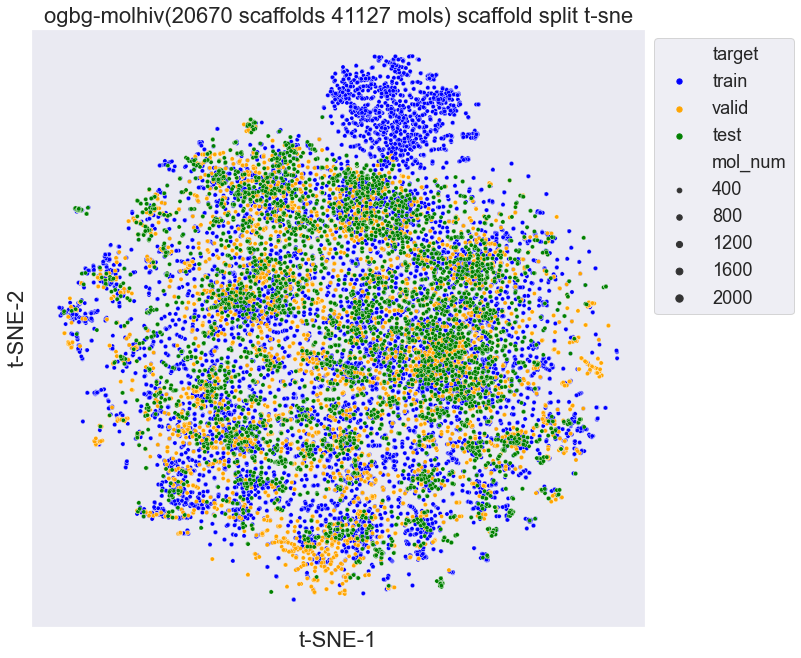

In [51]:
from plotter.plot_test import Plotter
plot = Orig_Plotter.from_smiles(scaffold_split_df["scaffold"], target=scaffold_split_df["split"] ,target_type="C", sim_type='structural')
plot.tsne(random_state=0)
plot.visualize_plot(kind = 'scatter', size = 11, 
                    title=f'{args.dataset}({len(all_scaffolds_set)} scaffolds {len(new_labeled_dataset)} mols) scaffold split t-sne', point_num = scaffold_split_df['num'])